# Model NEATM + REFLECT MODEL @python3.8
$D_{eff}=\frac{1329\times10^{-H_v/5}}{\sqrt{p_v}}$
$p_v=\frac{A_B}{q}$
$q_s=\frac{F_{sun}}{d^2}$
$T_{fit}=[\frac{(1-A)F_{sun}}{\eta\epsilon\sigma d}]^{1/4}$
$T=T(\theta,\phi)=T_{fit}\cos^{1/4}\theta\cos^{1/4}\phi,(-\frac{\pi}{2}<\theta<\frac{\pi}{2},-\frac{\pi}{2}<\phi<\frac{\pi}{2})$
$F_\lambda=F(\Delta,d,\alpha|\eta,D)$

$F_\lambda=\frac{\epsilon D^2}{2\Delta ^2}\frac{\pi h c^2}{\lambda ^5}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\frac{1}{exp(\frac{hc}{\lambda kT(\theta,\phi)}-1)}\cos^2 \phi\cos(\alpha-\theta)d\theta$

$F_\lambda=\frac{\epsilon D^2}{4\Delta ^2}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\pi B(T,\lambda)\cos^2 \phi\cos(\alpha-\theta)d\theta$


# MCMC_NEATM

## define const & import

In [1]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 
import pandas as pd
from tqdm import tqdm
import os
#import NEATM
from NEATM import *
#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9             #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
Rsun = 0.00465*au   #Rsun *m
Tsun = 5778         #Tsun  K
Hv = 21.7
G = 0.15
Ndd = 15
lamdai = [3.4,4.6,12,22]

## define MODEL FUNCTION
initial x:flux = delta, it will change "delta"!
list: a,b
a = b
a = b[:]

### Model hhq

In [2]:
def neatm_ohhq(Ndd,eta,D,delta,dd,alpha,lamda,A):   
    summ = 0.
    a = alpha-pi/2
    b = pi/2
    c = -pi/2          
    d = pi/2
    Tfit = np.power((1-A)*Fsun/(eta*epsi*sigma*dd*dd),0.25)
    #print(f"Tss = {Tfit-273}\n")
    dxdy = ((b-a)*(d-c)/(Ndd*Ndd)) 
    for j in range(Ndd):
        for i in range(Ndd):
            phii = (c+(d-c)*j/Ndd)
            thei = (a+(b-a)*i/Ndd)
            T = Tfit*np.power(np.cos(thei),0.25)*np.power(np.cos(phii),0.25)
            integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
            summ = summ + dxdy*integral
    F = (epsi*np.power(D,2)*pi*h*cl*cl)*summ/(2*np.power(delta*au,2)*np.power(lamda,5))
    F = F*(lamda)**2/cl*1e29
    return F
def Model_neatm_Ref_jhx(theta,x,lamda):
    '''
    theta = (eta,D,wf)
    x = (astp,obsp)
    x = (3.4x;4.6x;12x;22x)
    '''
    eta,D,wf = theta
    astp,obsp = x
    lamda1,lamda2,lamda3,lamda4 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial
    nn = len(astp)
    #print(nn)
    qutn = int(nn/4)
    flux = np.zeros(nn)
    #w1,w2 with Ref
    for i in range(qutn):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda1,eta,A)
        flux[i] = fluxi + wf*frLambi + frLommi
    for i in range(qutn,qutn*2):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda2,eta,A)
        flux[i] = fluxi + wf*frLambi + frLommi
    #w3,w3 without Ref
    for i in range(qutn*2,qutn*3):
        flux[i] = get_flux_noref(astp[i],obsp[i],D,lamda3,eta,A)
        #flux[i] ,frLambi,frLommi= get_flux_ref(astp[i],obsp[i],D,lamda3,eta,A)
    for i in range(qutn*3,qutn*4):
        flux[i] = get_flux_noref(astp[i],obsp[i],D,lamda3,eta,A)
        #flux[i] ,frLambi,frLommi= get_flux_ref(astp[i],obsp[i],D,lamda4,eta,A)
    return flux
    
def Model_neatm_ohhq(theta,x,lamda):
    eta,D = theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda1*1e-6,A)
    for i in range(int(nn/2),nn):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda2*1e-6,A)
    return flux

### Model reflect

## read data file

#### 处理原始数据 将坐标垂直叠加，方便直接计算12，22微米的流量

In [4]:
namelist = ['2003MA3','2010CO1','2010DG77','2010EX11','2010FC81','2010FH81','2010GS7','2010JN71','2010KX7','2010PW58','2010XP69','2019DD2']
name = '2010fh81'

#### read data & cal  
$x\equiv \Delta,d,\alpha$

In [7]:
obsec = np.loadtxt(f'newepoch_{name}.txt')
#name = namelist[1].lower()
obsec = np.loadtxt(f'newepoch_{name}.txt')
obsdat12 = np.loadtxt(f'w12_{name}.txt')
obsdat34 = np.loadtxt(f'w34_{name}.txt')
#ast-sun
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
#print('ast-sun',d_N)
#ast-earth
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#print('ast-earth',delta_N)
#earth-sun
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
#print('earth-sun',dd_N)
#alpha
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
#print("alpha",alpha_N/pi*180,'\n')
x = (delta_N,d_N,alpha_N)
x1 = np.vstack((obsec[:,0:3],obsec[:,0:3]))
x2 = np.vstack((obsec[:,3:6],obsec[:,3:6]))
x_jhx = (x1,x2)
astpp,obss = x_jhx
y = np.hstack((obsdat12[:],obsdat34[:]))
y


array([ 0.02865119,  0.02913015,  0.03135759,  0.03072859,  0.03670647,
        0.05893084,  0.03341509,  0.0384364 ,  0.02913015,  0.05364666,
        0.04910692,  0.03904295,  0.02997386,  0.03027908,  0.0520886 ,
        0.7529093 ,  0.04997383,  0.03397369,  0.03363122,  0.05132662,
        0.04672428,  0.0289163 ,  0.04495134,  0.06222181,  0.032775  ,
        0.03677415,  0.0582831 ,  0.03350755,  0.03840101,  0.04733067,
        0.03262441,  0.03425647,  0.04065769,  0.03158949,  0.05454346,
        0.03564041,  0.03301738,  0.04344529,  0.02972642,  0.06205012,
        0.03127106,  0.08691173,  0.07356621,  0.19475042,  0.10034099,
        0.15412688,  0.14937516,  0.16884119,  0.16168823,  0.12041439,
        0.10449088,  0.1       ,  0.14108421,  0.14678389,  0.07597634,
        0.1683753 ,  0.61755891,  0.13473437,  0.08992458,  0.11186092,
        0.12265306,  0.16124208,  0.16683163,  0.16183721,  0.39872953,
        0.54938702,  0.43398867,  0.41255171,  0.36064374,  0.33

In [8]:
Dtest = 346
pv = (1329*pow(10,-Hv/5)/(Dtest*0.001))**2
q = 0.29+0.684*G
At = q*pv
fluxi,frLambi,frLommi = get_flux_ref(x_jhx[0][0],x_jhx[1][0],346,3.4,1.2,At)
print(fluxi)
print(Model_neatm_Ref_jhx((1.2,346,1),x_jhx,lamdai))

0.21657481951015412
[ 0.23525963  0.23617183  0.23708884  0.23801069  0.23847479  0.23893743
  0.23940398  0.23986907  0.23986996  0.24033809  0.24127717  0.24127808
  0.24174813  0.24222217  0.24269473  0.24317129  0.24364637  0.24412549
  0.24460311  0.24508479  0.24604925  0.24701889  0.24897483  0.53364074
  0.53082032  0.52801883  0.52523603  0.52247184  0.52109532  0.51972603
  0.51835865  0.51699846  0.51564017  0.51293967  0.51159742  0.51025701
  0.50892361  0.50494463  0.50231459  0.49970179  0.49710611  2.0052761
  2.01226103  2.0192808   2.02633563  2.02988656  2.03342582  2.03699448
  2.04055149  2.04055835  2.04413807  2.05131755  2.05132446  2.05491733
  2.05854011  2.0621511   2.06579215  2.06942137  2.07308082  2.07672839
  2.08040636  2.08776903  2.09516907  2.11008954  4.42434801  4.40433561
  4.38442843  4.36462559  4.34492727  4.33510751  4.32533259  4.31556461
  4.30584127  4.296125    4.27678795  4.26716711  4.25755317  4.24798325
  4.21938878  4.20045814  4.1816

/home/astrohhq/learngit/JHX2010CO1/NEATM.py:187: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/home/astrohhq/learngit/JHX2010CO1/NEATM.py:115: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


##### plot $F_v^{ref}-\lambda$

In [9]:
astp,obsp = obsec[:,0:3],obsec[:,3:6]
delta0,d0,alpha0 = x[0][0],x[1][0],x[2][0]
arraylam = np.linspace(0,22,100)
#refledF = NEATM.get_flux_ref(346,delta0,d0,alpha0,arraylam*1e-6,0.9)
Dtest = 346
pv = (1329*pow(10,-Hv/5)/(Dtest*0.001))**2
q = 0.29+0.684*G
At = q*pv
refledF = get_flux_ref(astp[0],obsp[0],Dtest,3.4,1.2,At)
flux = neatm_ohhq(10,1.2,Dtest,delta0,d0,alpha0,3.4e-6,At)
print(Model_neatm_Ref_jhx((1.2,346,0.2),x_jhx,lamdai))


[ 0.22963491  0.23052857  0.23142694  0.23233006  0.23278472  0.23323796
  0.23369503  0.23415068  0.23415155  0.23461017  0.23553018  0.23553107
  0.23599158  0.23645598  0.23691895  0.23738584  0.23785128  0.23832067
  0.2387886   0.23926051  0.24020539  0.24115536  0.24307162  0.52077263
  0.51800558  0.51525716  0.51252713  0.50981541  0.50846504  0.50712178
  0.5057804   0.50444609  0.50311365  0.50046459  0.49914793  0.49783309
  0.49652513  0.49262214  0.49004239  0.48747959  0.48493362  2.00186073
  2.0088344   2.01584285  2.0228863   2.0264315   2.02996506  2.03352797
  2.03707924  2.03708608  2.04066003  2.04782793  2.04783482  2.05142191
  2.05503884  2.058644    2.06227918  2.06590254  2.06955608  2.07319777
  2.0768698   2.08422059  2.09160868  2.10650507  4.41653438  4.3965544
  4.37667944  4.35690865  4.33724219  4.3274383   4.31767919  4.30792699
  4.29821937  4.2885188   4.26921299  4.25960768  4.25000926  4.24045479
  4.21190646  4.19300635  4.17420655  4.15550675 32.

/tmp/ipykernel_1568850/637790495.py:15: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)


#### cal Flex
$F_v^{ast}(\lambda) = F_v^{th}(\lambda) + F_v^{ref}$


##### cal $F_v^{th}+F_v^{ref}$ in W1\W2

In [11]:
flux1234= Model_neatm_Ref_jhx((1.2,200,0.4),x_jhx,lamdai)
nt = len(flux1234)
nt

/home/astrohhq/learngit/JHX2010CO1/NEATM.py:187: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/home/astrohhq/learngit/JHX2010CO1/NEATM.py:115: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


164

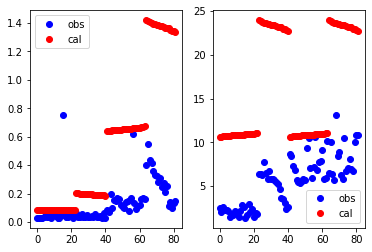

In [12]:
y12 = obsdat12
flux12 = flux1234[0:nt//2]
plt.subplot(1,2,1)
plt.plot(y12,'bo',label = 'obs')
plt.plot(flux12,'ro',label = 'cal')
plt.legend()
y34 = obsdat34
flux34 = flux1234[nt//2:]
plt.subplot(1,2,2)
plt.plot(y34,'bo',label = 'obs')
plt.plot(flux34,'ro',label = 'cal')
plt.legend()

# MCMC

In [13]:
#initial
eta_gs = 1.2
D_gs = 200
eta_gss = [0.5,5]
D_gss = [1,500]
wf_gs = 0.2
wf_gss = [0,0.5]
yerr = y[:]*0.1

In [14]:
#MCMC Function
def log_likelihood(theta, x, y, yerr):
    eta,D,wf = theta
    #print(theta,x,y,yerr)
    model = Model_neatm_Ref_jhx(theta,x,lamdai)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
def log_prior(theta):
    eta,D,wf = theta
    #print(theta,x,y,yerr)
    if eta_gss[0]< eta < eta_gss[1] and D_gss[0] < D < D_gss[1] and wf_gss[0] < wf < wf_gss[1]:
        return 0.0
    return -np.inf
    #return 0
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
     #   print('hi','-inf')
        return -np.inf
    #print(theta,x,y,yerr)
    yy=lp + log_likelihood(theta, x, y, yerr)
    #print('hi',yy)
    return yy


In [15]:
#initial para guesses
eta = eta_gs
D = D_gs
wf = wf_gs
theta = [eta, D,wf]

In [16]:
import emcee
#initialize sampler
ndim, nwalkers = len(theta), 10
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x_jhx, y, yerr))
pos = [theta + 1e-6*np.random.randn(ndim) for i in range(nwalkers)]
#run mcmc
sampler.run_mcmc(pos, 1000, progress=True);

/home/astrohhq/learngit/JHX2010CO1/NEATM.py:187: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/home/astrohhq/learngit/JHX2010CO1/NEATM.py:115: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
100%|██████████| 1000/1000 [21:50<00:00,  1.31s/it]


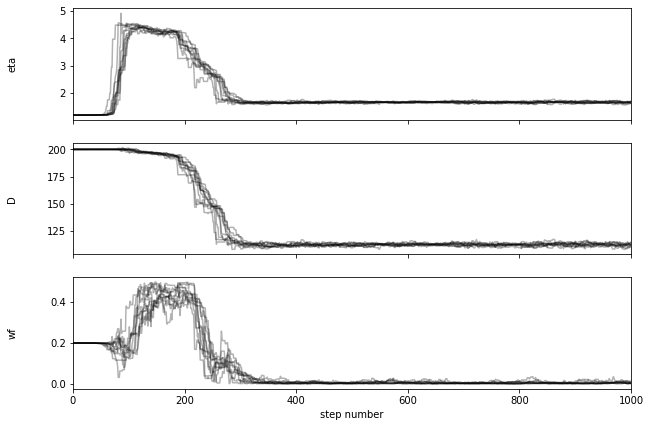

In [18]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["eta", "D", "wf"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");

In [19]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 80.82360733 125.50061636 114.71798537]

In [34]:
frac = sampler.acceptance_fraction
frac

array([0.581, 0.57 , 0.577, 0.563, 0.587, 0.555, 0.542, 0.532, 0.592,
       0.544])

(400, 3)


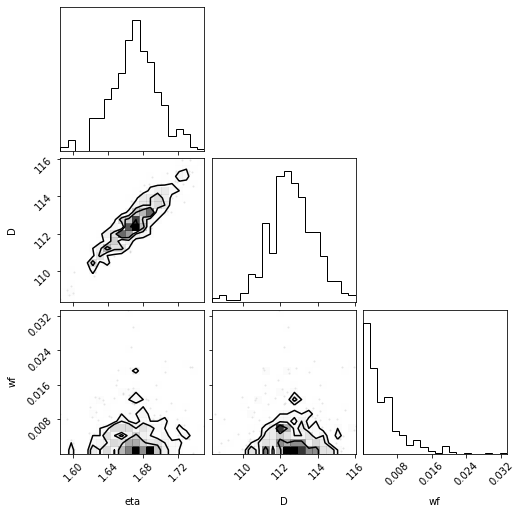

In [22]:
#--------------------------
flat_samples = sampler.get_chain(discard=400, thin=15, flat=True)
print(flat_samples.shape)
import corner
fig = corner.corner(
flat_samples, labels=labels, truths=[eta_gs, D_gs,wf_gs]
);

In [23]:
from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    #print(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))
print(Math(txt))
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
pv = (1329*pow(10,-Hv/5)/(D_fit*0.001))**2
print('eta_gs = ',eta_gs,'D_gs= ',D_gs,'pv=',pv)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>
eta_gs =  1.2 D_gs=  200 pv= 0.291251516836995


In [24]:
def loss(obs,cal,err):
    l = len(obs)
    return sum(((obs-cal)/err)**2)/l
print('LossFunction = ',loss(y,Model_neatm_Ref_jhx(theta,x_jhx,lamdai),y*0.1))

LossFunction =  1476.6647512643133


/home/astrohhq/learngit/JHX2010CO1/NEATM.py:187: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/home/astrohhq/learngit/JHX2010CO1/NEATM.py:115: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


/home/astrohhq/learngit/JHX2010CO1/NEATM.py:187: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/home/astrohhq/learngit/JHX2010CO1/NEATM.py:115: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


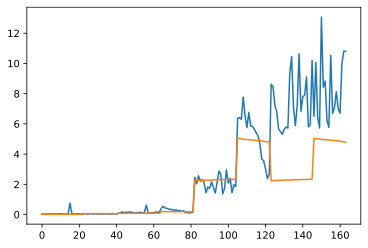

In [32]:
plt.plot(y)
plt.plot(Model_neatm_Ref_jhx(theta,x_jhx,lamdai))

In [27]:
import pandas as pd
#rawdata = pd.read_csv(f'time_{name}.txt')
#timelist = rawdata['mjd'].tolist()
yerr = y*0.1

eta_fit =  1.6705838124921626 D_fit=  112.56176206641224 pv =  0.291251516836995


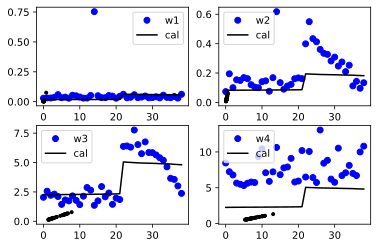

In [28]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def loss(cal,y,yerr):
    nn = len(y)
    return sum(((cal-y)/yerr)**2)/nn
eta_low,eta_fit,eta_high = np.percentile(flat_samples[:, 0], [16, 50, 84])
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
wf_low,wf_fit,wf_high = np.percentile(flat_samples[:, 2], [16, 50, 84])

print('eta_fit = ',eta_fit,'D_fit= ',D_fit,'pv = ',(1329*pow(10,-Hv/5)/(D_fit*0.001))**2)
theta = eta_fit,D_fit,wf_fit
flux = Model_neatm_Ref_jhx(theta,x_jhx,lamdai)
qq = nt//4
y12 = obsdat12
flux12 = flux[0:nt//2]
plt.subplot(2,2,1)
plt.plot(y12[1:qq-1],'bo',label = 'w1')
plt.errorbar(y12[1:qq-1],yerr[1:qq-1],fmt=".k", capsize=1.0)
plt.plot(flux12[1:qq-1],'k',label = 'cal')
plt.legend()
plt.subplot(2,2,2)
plt.plot(y12[qq+1:2*qq-1],'bo',label = 'w2')
plt.errorbar(y12[qq+1:2*qq-1],yerr[qq+1:2*qq-1],fmt=".k", capsize=1.0)
plt.plot(flux12[qq+1:2*qq-1],'k',label = 'cal')
plt.legend()
y34 = obsdat34
flux34 = flux[nt//2:]
plt.subplot(2,2,3)
plt.plot(y34[1:qq-1],'bo',label = 'w3')
plt.errorbar(y34[1:qq-1],y34[1:qq-1]*0.1,fmt=".k", capsize=1.0)
plt.plot(flux34[1:qq-1],'k',label = 'cal')
plt.legend()
plt.subplot(2,2,4)
plt.plot(y34[qq+1:2*qq-1],'bo',label = 'w4')
plt.errorbar(y34[qq+1:2*qq-1],y34[qq+1:2*qq-1]*0.1,fmt=".k", capsize=1.0)
plt.plot(flux34[qq+1:2*qq-1],'k',label = 'cal')
plt.legend()



eta_fit =  1.6705838124921626 D_fit=  112.56176206641224 pv =  0.291251516836995


/home/astrohhq/learngit/JHX2010CO1/NEATM.py:187: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/home/astrohhq/learngit/JHX2010CO1/NEATM.py:115: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


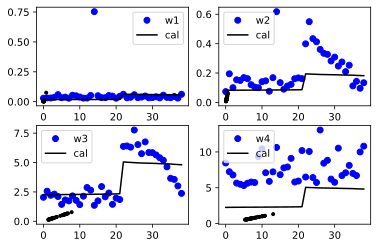

In [29]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def loss(cal,y,yerr):
    nn = len(y)
    return sum(((cal-y)/yerr)**2)/nn
eta_low,eta_fit,eta_high = np.percentile(flat_samples[:, 0], [16, 50, 84])
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
wf_low,wf_fit,wf_high = np.percentile(flat_samples[:, 2], [16, 50, 84])

print('eta_fit = ',eta_fit,'D_fit= ',D_fit,'pv = ',(1329*pow(10,-Hv/5)/(D_fit*0.001))**2)
theta = eta_fit,D_fit,wf_fit
flux = Model_neatm_Ref_jhx(theta,x_jhx,lamdai)
qq = nt//4
y12 = obsdat12
flux12 = flux[0:nt//2]
plt.subplot(2,2,1)
plt.plot(y12[1:qq-1],'bo',label = 'w1')
plt.errorbar(y12[1:qq-1],yerr[1:qq-1],fmt=".k", capsize=1.0)
plt.plot(flux12[1:qq-1],'k',label = 'cal')
plt.legend()
plt.subplot(2,2,2)
plt.plot(y12[qq+1:2*qq-1],'bo',label = 'w2')
plt.errorbar(y12[qq+1:2*qq-1],yerr[qq+1:2*qq-1],fmt=".k", capsize=1.0)
plt.plot(flux12[qq+1:2*qq-1],'k',label = 'cal')
plt.legend()
y34 = obsdat34
flux34 = flux[nt//2:]
plt.subplot(2,2,3)
plt.plot(y34[1:qq-1],'bo',label = 'w3')
plt.errorbar(y34[1:qq-1],y34[1:qq-1]*0.1,fmt=".k", capsize=1.0)
plt.plot(flux34[1:qq-1],'k',label = 'cal')
plt.legend()
plt.subplot(2,2,4)
plt.plot(y34[qq+1:2*qq-1],'bo',label = 'w4')
plt.errorbar(y34[qq+1:2*qq-1],y34[qq+1:2*qq-1]*0.1,fmt=".k", capsize=1.0)
plt.plot(flux34[qq+1:2*qq-1],'k',label = 'cal')
plt.legend()

